In [30]:
%load_ext autoreload
%autoreload 2

In [49]:
from dante.latent_features.extractor import ModelFeatureExtractor
from data_loading import PrepareTitan

import os
import torch
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data and model

```titan_data_dir``` should correspond to the path where data from https://ibm.box.com/v/titan-dataset is stored.

In [2]:
titan_data_dir = 'titan_data'
model_dir = os.path.join(titan_data_dir, 'trained_model')

In [3]:
titan = PrepareTitan(model_path=model_dir)

In [4]:
train_loader = titan.get_data(
    test=False,
    affinity_filepath=os.path.join(titan_data_dir, 'trained_model_train.csv'),
    receptor_filepath=os.path.join(titan_data_dir, 'tcr_full.csv'),
    ligand_filepath=os.path.join(titan_data_dir, 'epitopes.smi')
)

test_loader = titan.get_data(
    test=True,
    affinity_filepath=os.path.join(titan_data_dir, 'trained_model_test.csv'),
    receptor_filepath=os.path.join(titan_data_dir, 'tcr_full.csv'),
    ligand_filepath=os.path.join(titan_data_dir, 'epitopes.smi')
)

# Load model
model = titan.get_model()
model.cuda()
model.eval();

ERROR:pytoda.datasets.smiles_dataset:Since you provided a smiles_language, the following parameters to this class will be ignored: canonical, augment, kekulize, all_bonds_explicit, selfies, sanitize, all_hs_explicit, remove_bonddir, remove_chirality, randomize, add_start_and_stop, padding, padding_length, device.
Here are the problems:
ERROR:pytoda.datasets.smiles_dataset:Provided arg canonical:True does not match the smiles_language value: False NOTE: smiles_language value takes preference!!
ERROR:pytoda.datasets.smiles_dataset:Provided arg add_start_and_stop:True does not match the smiles_language value: False NOTE: smiles_language value takes preference!!
ERROR:pytoda.datasets.smiles_dataset:Provided arg padding:True does not match the smiles_language value: False NOTE: smiles_language value takes preference!!
ERROR:pytoda.datasets.smiles_dataset:Provided arg padding_length:500 does not match the smiles_language value: None NOTE: smiles_language value takes preference!!
ERROR:pytoda

# Extract hidden activations

To choose a layer indicate the full submodule list that can be explored calling ```model```.

In [5]:
submodules_list = ['dense_layers', 'dense_2']

Override ```batch_to_input``` to indicate which part of the batch contains the model's input.

In [8]:
class TitanExtractor(ModelFeatureExtractor):
    
    def batch_to_input(self, batch):
        
        l, r, y = batch
        
        return l, r

- Extract features from the given model ```model```, for each instance in ```train_loader``` or ```test_loader```.
- The output will be stored in the ```out_dir``` ```output```, that should be either created if non-existing or replaced by another path.

In [11]:
train_latent_features = TitanExtractor(
    model = model, 
    dataloader = (train_loader, 'train'), 
    submodules_list = submodules_list,
    model_name = 'prova14',
    out_dir = './output'
).run()

In [13]:
train_latent_features.shape

torch.Size([44800, 512])

In [12]:
test_latent_features = TitanExtractor(
    model = model, 
    dataloader = (test_loader, 'test'), 
    submodules_list = submodules_list,
    model_name = 'prova14',
    out_dir = './output'
).run()

In [14]:
test_latent_features.shape

torch.Size([2304, 512])

# Save prediction (aleatoric) uncertainty and true labels

In [21]:
def extract_y_hat_true(model, data_loader):
    
    y_true = []
    y_hat = []

    for l, r, batch_y_true in tqdm(data_loader):

        batch_y_true = batch_y_true.cpu()
        batch_y_true = batch_y_true.flatten()
        y_true.append(batch_y_true)

        with torch.no_grad():
            batch_y_hat, _ = model(l, r)

        batch_y_hat = batch_y_hat.cpu()
        batch_y_hat = batch_y_hat.flatten()
        y_hat.append(batch_y_hat)

    y_hat = torch.cat(y_hat)
    y_true = torch.cat(y_true)
    
    return y_hat, y_true

In [22]:
y_train_hat, y_train_true = extract_y_hat_true(model, train_loader)
y_test_hat, y_test_true = extract_y_hat_true(model, test_loader)

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [45]:
def aleatoric_uncertainty(prediction_proba):
    return -(np.log2(prediction_proba) * prediction_proba + np.log2(1-prediction_proba) * (1-prediction_proba))

In [50]:
entropy_test = aleatoric_uncertainty(y_test_hat)

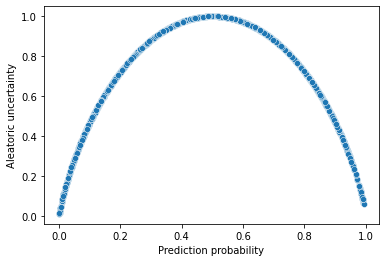

In [54]:
sns.scatterplot(x=y_test_hat, y=entropy_test)
plt.xlabel("Prediction probability")
plt.ylabel("Aleatoric uncertainty");

# Extract Epistemic Uncertainty

## Mahalanobis

In [36]:
from dante.layer_scoring.mahalanobis import Mahalanobis

maha = Mahalanobis().fit(
    train_latent_features.numpy(), 
    y_train_true.numpy())

maha_scores = -maha.score(test_latent_features.numpy())

## Aklpe

In [ ]:
pip install pynndescent

In [42]:
from dante.layer_scoring.aklpe import Aklpe
from dante.nearest_neighbors.pynndescent import NearestNeighbors

nn = NearestNeighbors

aklpe = Aklpe(
    nearest_neighbors = nn,
    n_neighbors=50, 
    n_bootstraps=1)

aklpe.fit(train_latent_features.numpy())

aklpe_scores, aklpe_pvals = aklpe.score(test_latent_features.numpy())

# Plotting

In [44]:
import seaborn as sns

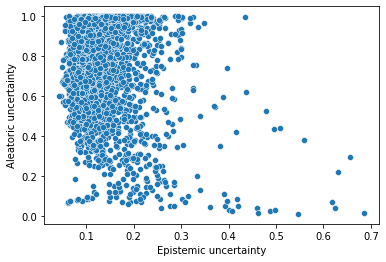

In [57]:
sns.scatterplot(x=aklpe_scores, y=entropy_test)
plt.xlabel("Epistemic uncertainty")
plt.ylabel("Aleatoric uncertainty");